# Azure Cognitive Search Vector Search Code Sample with Azure AI Vision Image Embedding API
This code demonstrates how to create Azure Cognitive Search Index with Azure AI Vision Image Embedding API and Azure Python SDK
## Prerequisites
To run the code, install the following packages. Please use the latest pre-release version `pip install azure-search-documents --pre`. This sample currently uses version `11.4.0b11`.

In [ ]:
! pip install azure-search-documents==11.4.0b11 --quiet
! pip install python-dotenv ipython --quiet
! pip install tenacity --quiet
! pip install azure-identity --quiet

## Import required libraries and environment variables

In [1]:
# Import required libraries  
import os  
import json  
import requests
import http.client, urllib.parse
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv  
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import (
    RawVectorQuery,
)
from azure.search.documents.indexes.models import (  
 
    ExhaustiveKnnParameters,  
    ExhaustiveKnnVectorSearchAlgorithmConfiguration,
    HnswParameters,  
    HnswVectorSearchAlgorithmConfiguration,
    SimpleField,
    SearchField,  
    SearchFieldDataType,  
    SearchIndex,  
    VectorSearch,  
    VectorSearchAlgorithmKind,  
    VectorSearchProfile,  
)

from IPython.display import Image, display
  
load_dotenv()  
service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")  
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
api_version = os.getenv("AZURE_SEARCH_API_VERSION")
key = os.getenv("AZURE_SEARCH_ADMIN_KEY")  
aiVisionApiKey = os.getenv("AZURE_AI_VISION_API_KEY")  
aiVisionRegion = os.getenv("AZURE_AI_VISION_REGION")
credential = DefaultAzureCredential()

# Create image embedding

Vectorize images with image embedding API 

In [2]:
@retry(stop=stop_after_attempt(5), wait=wait_fixed(1))
def get_image_vector(image_path, key, region):
    headers = {
        'Ocp-Apim-Subscription-Key': key,
    }

    params = urllib.parse.urlencode({
        'model-version': '2023-04-15',
    })

    try:
        if image_path.startswith(('http://', 'https://')):
            headers['Content-Type'] = 'application/json'              
            body = json.dumps({"url": image_path})
        else:
            headers['Content-Type'] = 'application/octet-stream'
            with open(image_path, "rb") as filehandler:
                image_data = filehandler.read()
                body = image_data

        conn = http.client.HTTPSConnection(f'{region}.api.cognitive.microsoft.com', timeout=3)
        conn.request("POST", "/computervision/retrieval:vectorizeImage?api-version=2023-04-01-preview&%s" % params, body, headers)
        response = conn.getresponse()
        data = json.load(response)
        conn.close()

        if response.status != 200:
            raise Exception(f"Error processing image {image_path}: {data.get('message', '')}")

        return data.get("vector")

    except (requests.exceptions.Timeout, http.client.HTTPException) as e:
        print(f"Timeout/Error for {image_path}. Retrying...")
        raise


input_json_file = '../data/images/apples/input.json'
output_folder = '../data/images/apples/output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

    with open(input_json_file, 'r') as infile:
        images = json.load(infile)

    results = []
    file_count = 1
    images_per_file = 50

    for idx, image_data in enumerate(images):
        if image_data.get('image_path', None):
            try:
                vector = get_image_vector(
                    os.path.join(os.path.dirname(input_json_file), image_data.get('image_path', None)),
                    aiVisionApiKey,
                    aiVisionRegion
                )
            except Exception as e:
                print(f"Error processing image at index {idx}: {e}")
                vector = None
            
            # Only save result if vector is present AND description is present
            description_present = image_data.get('description', '')
            
            if vector and description_present:
                result = {
                    "id": idx,
                    "image_vector": vector,
                    "description": description_present  # Always add the description, even if it's an empty string
                }

                results.append(result)

        print(f"Processed image {idx+1}/{len(images)}")

        if (idx + 1) % images_per_file == 0 or (idx + 1) == len(images):
            print(f"Saving results to file {file_count}")
            output_file_path = os.path.join(output_folder, f"output_{file_count}.json")
            with open(output_file_path, 'w') as outfile:
                json.dump(results, outfile, indent=4)
            results = []
            file_count += 1

print(f"Results are saved to {output_folder}")

Results are saved to ../data/images/apples/output


# Create an index

Create your search index schema and vector search configuration:

In [3]:
# Create a search index 
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)  
fields = [  
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),  
    SearchField(name="description", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),  
    SearchField(
        name="image_vector",  
        hidden=True,
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
        searchable=True,
        vector_search_dimensions=1024,  
        vector_search_profile="myHnswProfile"
    ),  
]  
  
# Configure the vector search configuration  
vector_search = VectorSearch(  
    algorithms=[  
        HnswVectorSearchAlgorithmConfiguration(  
            name="myHnsw",  
            kind=VectorSearchAlgorithmKind.HNSW,  
            parameters=HnswParameters(  
                m=4,  
                ef_construction=400,  
                ef_search=1000,  
                metric="cosine",  
            ),  
        ),  
            ExhaustiveKnnVectorSearchAlgorithmConfiguration(  
            name="myExhaustiveKnn",  
            kind=VectorSearchAlgorithmKind.EXHAUSTIVE_KNN,  
            parameters=ExhaustiveKnnParameters(  
                metric="cosine",  
            ),  
        ), 
    ],  
   profiles=[  
        VectorSearchProfile(  
            name="myHnswProfile",  
            algorithm="myHnsw",  
        ),  
        VectorSearchProfile(  
            name="myExhaustiveKnnProfile",  
            algorithm="myExhaustiveKnn",  
        ),  
    ],  
)  
  
# Create the search index with the vector search configuration  
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)  
result = index_client.create_or_update_index(index)  
print(f"{result.name} created") 

apple-test14-index created


# Push local data to the index

In [4]:
# Endpoint URL for the index
endpoint = f"{service_endpoint}/indexes/{index_name}/docs/index?api-version={api_version}"

# Headers for the request
headers = {
    'Content-Type': 'application/json',
    'api-key': key
}

# Iterate through each JSON file in the directory
for filename in os.listdir(output_folder):
    if filename.endswith(".json"):
        file_path = os.path.join(output_folder, filename)

        # Read the JSON file
        with open(file_path, 'r') as file:
            items = json.load(file)

        # Check if the file's root is an array (list) and wrap it in an object if necessary
        if isinstance(items, list):
            # Process each item in the JSON file
            documents = []
            for item in items:
                document = {
                    "id": str(item["id"]),
                    "image_vector": item["image_vector"],
                    "description": item["description"]
                }
                documents.append(document)

            # Format the data for Azure Cognitive Search
            formatted_data = {"value": documents}
        else:
            # If the root is already an object, use it directly
            formatted_data = items


        # Make the POST request to push data
        response = requests.post(endpoint, headers=headers, json=formatted_data)

        # Check response status
        if response.status_code == 200:
            print(f"Data from {filename} successfully indexed")
        else:
            print(f"Error indexing data from {filename}:", response.json())

Data from output_1.json successfully indexed


# Perform an image vector search
Perform a vector search to find the most relevant images based on an image query

Search results for ../data/images/apples/two_apples.jpeg:


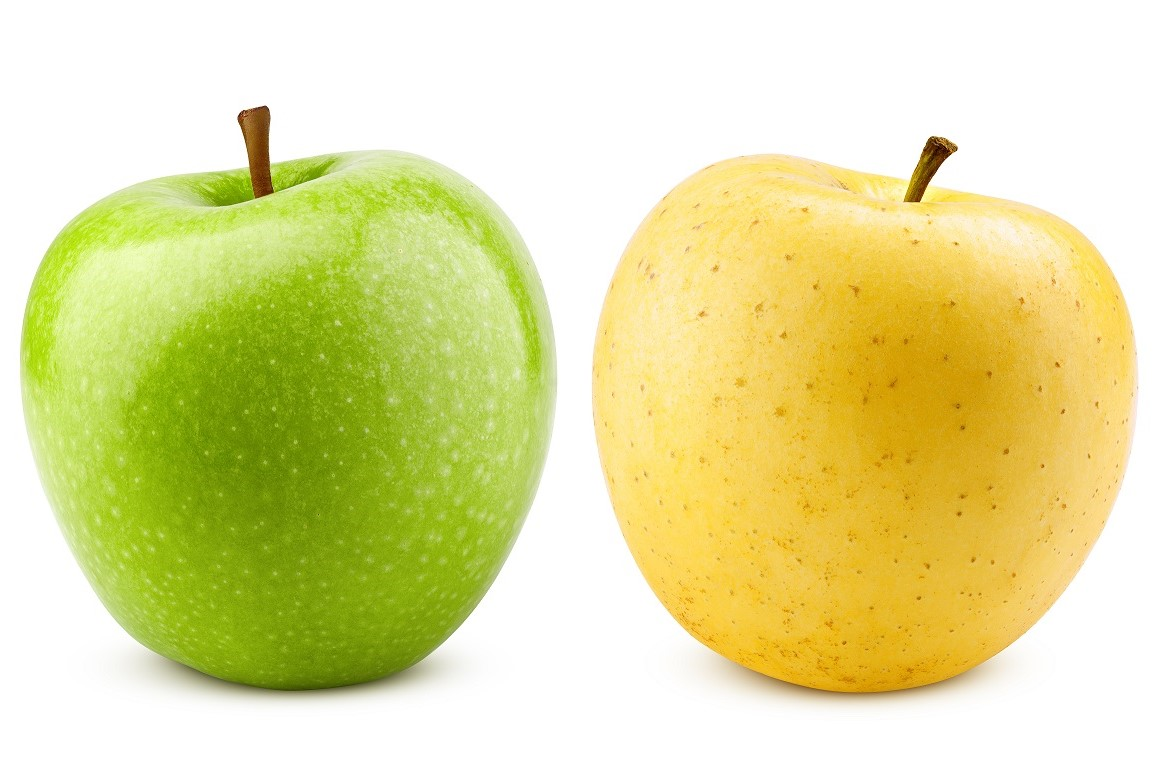

Apple Type: GrannySmith


Apple Type: GoldenDelicious




In [5]:
 # Generate text embeddings for the query  
query_image_path = "../data/images/apples/two_apples.jpeg"  
# Initialize the SearchClient  
search_client = SearchClient(service_endpoint, index_name, AzureKeyCredential(key))  
vector_query = RawVectorQuery(vector=get_image_vector(query_image_path, aiVisionApiKey, aiVisionRegion),
                              k=2, 
                              fields="image_vector")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["description"]  
)   
  
# Print the search results 
print(f"Search results for {query_image_path}:") 
display(Image(query_image_path))
for result in results:
    print(f"Apple Type: {result['description']}")
    print("\n") 